# Importaciones

In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import re
from sklearn import metrics

# Carga de datos

In [82]:
# Cargar los datos
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
sample_df = pd.read_csv('data/sample_submission.csv')

In [83]:
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


# Preprocesar 'Weight' y 'Ram'
for col, unit in [('Weight', 'kg'), ('Ram', 'GB')]:
    train_df[col] = train_df[col].str.replace(unit, '', regex=False).astype(float if col == 'Weight' else int)
    test_df[col] = test_df[col].str.replace(unit, '', regex=False).astype(float if col == 'Weight' else int)

# Extraer resolución y calcular 'Resolution'
for df in [train_df, test_df]:
    df[['res_width', 'res_height']] = df['ScreenResolution'].str.extract(r'(\d{3,4})x(\d{3,4})').astype(float)
    df['Resolution'] = df['res_width'] * df['res_height']
    df.drop(columns=['res_width', 'res_height', 'ScreenResolution'], inplace=True)

# Procesar 'Memory'
def parse_memory_optimized(memory_str):
    if isinstance(memory_str, str):
        memory_str = memory_str.lower()
        ssd = sum(int(size) * (1024 if unit == 'tb' else 1)
                  for size, unit in re.findall(r'(\d+)(tb|gb) ssd', memory_str))
        hdd = sum(int(size) * (1024 if unit == 'tb' else 1)
                  for size, unit in re.findall(r'(\d+)(tb|gb) hdd', memory_str))
        flash = int('flash storage' in memory_str)
        hybrid = int('hybrid' in memory_str)
        return ssd, hdd, flash, hybrid
    return 0, 0, 0, 0

for df in [train_df, test_df]:
    df[['Memory_SSD', 'Memory_HDD', 'Flash_Storage', 'Hybrid']] = df['Memory'].apply(parse_memory_optimized).apply(pd.Series)
    df.drop(columns=['Memory'], inplace=True)

# Procesar 'Cpu'
def parse_cpu_optimized(cpu_str):
    if isinstance(cpu_str, str):
        cpu_str = cpu_str.lower()
        cores = int(re.search(r'(\d+)\s*core', cpu_str).group(1)) if re.search(r'(\d+)\s*core', cpu_str) else 0
        frequency = float(re.search(r'(\d+\.?\d*)\s*ghz', cpu_str).group(1)) if re.search(r'(\d+\.?\d*)\s*ghz', cpu_str) else 0.0
        family = 'Intel' if 'intel' in cpu_str else 'AMD' if 'amd' in cpu_str else 'Other'
        series = re.search(r'(i\d|ryzen \d)', cpu_str)
        series = series.group(1) if series else 'Other'
        return cores, frequency, family, series
    return 0, 0.0, 'Other', 'Other'

for df in [train_df, test_df]:
    df[['Cpu_Cores', 'Cpu_Frequency', 'Cpu_Family', 'Cpu_Series']] = df['Cpu'].apply(parse_cpu_optimized).apply(pd.Series)
    df.drop(columns=['Cpu'], inplace=True)
    df = pd.get_dummies(df, columns=['Cpu_Family', 'Cpu_Series'], drop_first=True)

# Procesar 'Gpu'
def parse_gpu_optimized(gpu_str):
    if isinstance(gpu_str, str):
        gpu_str = gpu_str.lower()
        brand = next((b for b in ['nvidia', 'amd', 'intel'] if b in gpu_str), 'Other').capitalize()
        family = re.search(r'(gtx|rtx|radeon|iris|hd graphics)', gpu_str)
        family = family.group(1) if family else 'Other'
        model = int(re.search(r'\b(\d+)\b', gpu_str).group(1)) if re.search(r'\b(\d+)\b', gpu_str) else 0
        return brand, family, model
    return 'Other', 'Other', 0

for df in [train_df, test_df]:
    df[['Gpu_Brand', 'Gpu_Family', 'Gpu_Model']] = df['Gpu'].apply(parse_gpu_optimized).apply(pd.Series)
    df.drop(columns=['Gpu'], inplace=True)
    df = pd.get_dummies(df, columns=['Gpu_Brand', 'Gpu_Family'], drop_first=True)

# Procesar columnas categóricas
categorical_cols = ['Company', 'TypeName', 'OpSys']
for col in categorical_cols:
    dummies_train = pd.get_dummies(train_df[col], prefix=col, drop_first=True)
    dummies_test = pd.get_dummies(test_df[col], prefix=col, drop_first=True)
    train_df = pd.concat([train_df, dummies_train], axis=1).drop(columns=[col])
    test_df = pd.concat([test_df, dummies_test], axis=1).drop(columns=[col])

# Asegurar consistencia entre train y test
missing_cols_test = set(train_df.columns) - set(test_df.columns)
missing_cols_train = set(test_df.columns) - set(train_df.columns)

for col in missing_cols_test:
    test_df[col] = 0
for col in missing_cols_train:
    train_df[col] = 0

train_df = train_df.sort_index(axis=1)
test_df = test_df.sort_index(axis=1)

# Separar datos
X_train_improved = train_df.drop(columns=["Price_euros"])
y_train = train_df["Price_euros"]

# Definir y entrenar modelos
models = {
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, n_jobs=-1)
}

feature_importances = pd.DataFrame(index=X_train_improved.columns)

for model_name, model in models.items():
    print(f"Entrenando modelo: {model_name}...")
    model.fit(X_train_improved, y_train)
    
    if hasattr(model, "feature_importances_"):
        feature_importances[model_name] = model.feature_importances_

if not feature_importances.empty:
    feature_importances['Average Importance'] = feature_importances.mean(axis=1)
    feature_importances = feature_importances.sort_values(by='Average Importance', ascending=False)

    feature_importances.reset_index(inplace=True)
    feature_importances.rename(columns={'index': 'Feature'}, inplace=True)

    plt.figure(figsize=(14, 8))
    sns.barplot(data=feature_importances, x='Average Importance', y='Feature', orient='h')
    plt.title("Importancia Promedio de Características")
    plt.xlabel("Importancia Promedio")
    plt.ylabel("Características")
    plt.show()


Entrenando modelo: Random Forest...


ValueError: could not convert string to float: 'Intel'

## Definir modelos mas adecuados para predecir y evaluar su rendimiento

## Predicciones y archivo salida

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import numpy as np

# Definir los modelos y sus hiperparámetros
models_params = {
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42, n_jobs=-1),
        "params": {
            "n_estimators": [100, 150, 200],
            "max_depth": [10, 15, None],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
        },
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.05],
            "max_depth": [4, 6],
            "subsample": [0.8, 1.0],
        },
    },
    "XGBoost": {
        "model": XGBRegressor(random_state=42, n_jobs=-1),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [6, 8],
            "learning_rate": [0.05, 0.1],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0],
        },
    },
}

# Diccionario para almacenar resultados
results = {}

# Iterar sobre los modelos y realizar GridSearchCV
for model_name, config in models_params.items():
    print(f"\nOptimizing {model_name}...")
    grid_search = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        cv=3,  # Reducir número de folds para acelerar
        scoring="neg_mean_absolute_error",  # MAE como métrica
        n_jobs=-1,
        verbose=1,
    )
    # Ajustar el modelo con los datos de entrenamiento
    grid_search.fit(X_train_split, y_train_log)
    
    # Obtener el mejor modelo y parámetros
    best_model = grid_search.best_estimator_
    y_pred_log = best_model.predict(X_val_split)
    y_pred = np.expm1(y_pred_log)  # Revertir la transformación logarítmica
    mae = mean_absolute_error(y_val_split, y_pred)
    
    # Guardar resultados
    results[model_name] = {
        "best_model": best_model,
        "best_params": grid_search.best_params_,
        "mae": mae,
    }
    
    print(f"Mejores parámetros para {model_name}: {grid_search.best_params_}")
    print(f"MAE para {model_name}: {mae}")

# Identificar el mejor modelo
best_model_name = min(results, key=lambda x: results[x]["mae"])
best_model = results[best_model_name]["best_model"]
print(f"\nEl mejor modelo es {best_model_name} con un MAE de {results[best_model_name]['mae']}")

# Exportar resultados del mejor modelo
best_model_params = results[best_model_name]["best_params"]
print(f"\nParámetros del mejor modelo: {best_model_params}")


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 64 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           391 non-null    int64  
 1   laptop_ID                    391 non-null    int64  
 2   Company                      391 non-null    object 
 3   Product                      391 non-null    object 
 4   Inches                       391 non-null    float64
 5   ScreenResolution             391 non-null    object 
 6   Ram                          391 non-null    int32  
 7   Gpu                          391 non-null    object 
 8   Weight                       391 non-null    float64
 9   Resolution                   391 non-null    float64
 10  Memory_SSD                   391 non-null    int64  
 11  Memory_HDD                   391 non-null    int64  
 12  Flash_Storage                391 non-null    int64  
 13  Hybrid              

In [ ]:
# Predecir en el conjunto de prueba
y_pred_test_log = best_model.predict(X_test_improved)

# Invertir la transformación logarítmica para obtener los valores de precio originales
y_pred_test = np.expm1(y_pred_test_log)

if 'id' in test_df.columns:
    output_df = test_df[['id']].copy()
    output_df['Price_euros'] = y_pred_test
    output_df.to_csv('laptop_price_predictions.csv', index=False)
else:
    output_df = pd.DataFrame({
        'Price_euros': y_pred_test
    })
    output_df.to_csv('laptop_price_predictions.csv', index=False)

print("Archivo de predicciones guardado como laptop_price_predictions.csv")



Archivo de predicciones guardado como laptop_price_predictions.csv


MAE: 166.05
MSE: 66137.15597157374
RMSE: 257.17


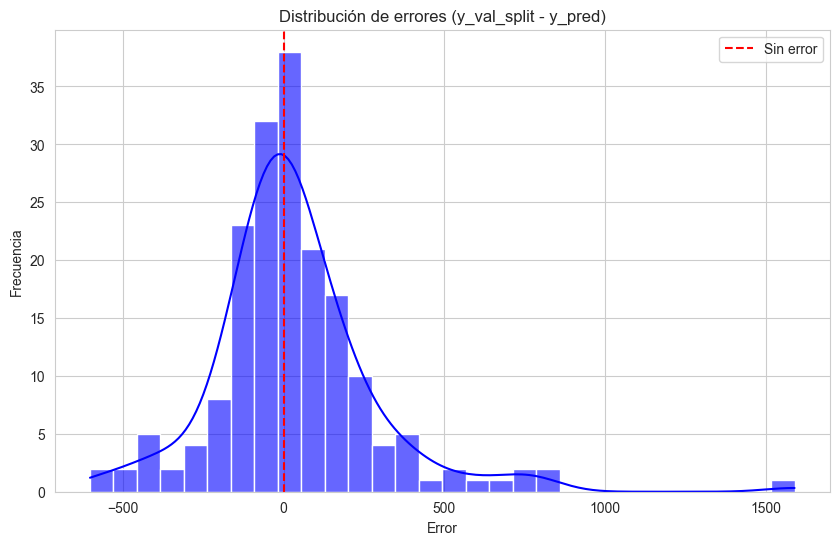

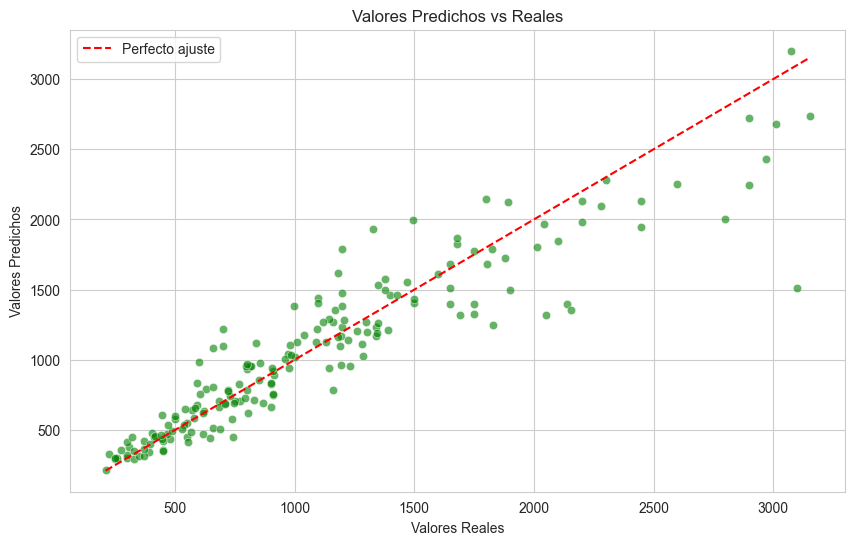

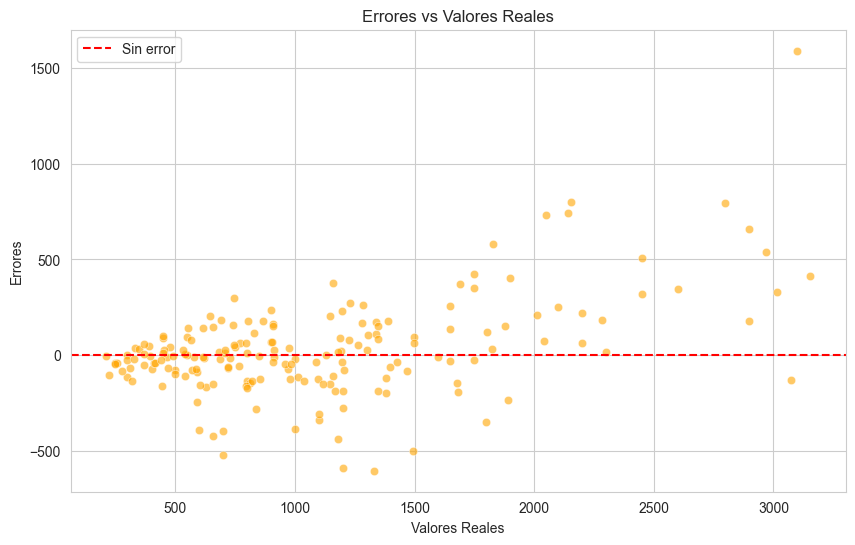

In [ ]:
# Predecir con el modelo entrenado
y_pred_log = best_model.predict(X_val_split)
y_pred = np.expm1(y_pred_log)  # Revertir la transformación logarítmica

# Calcular los errores
errors = y_val_split - y_pred
mae = mean_absolute_error(y_val_split, y_pred)
rmse = np.sqrt(mean_squared_error(y_val_split, y_pred))

# Mostrar métricas de error
print(f"MAE: {mae:.2f}")
print('MSE:', metrics.mean_squared_error(y_val_split, y_pred))
print(f"RMSE: {rmse:.2f}")

# Gráfico 1: Histograma de errores
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30, color='blue', alpha=0.6)
plt.title("Distribución de errores (y_val_split - y_pred)")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.axvline(x=0, color='red', linestyle='--', label='Sin error')
plt.legend()
plt.show()

# Gráfico 2: Valores predichos vs valores reales
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val_split, y=y_pred, alpha=0.6, color='green')
plt.plot([y_val_split.min(), y_val_split.max()], [y_val_split.min(), y_val_split.max()], color='red', linestyle='--', label='Perfecto ajuste')
plt.title("Valores Predichos vs Reales")
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.legend()
plt.show()

# Gráfico 3: Gráfico de dispersión de errores
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val_split, y=errors, alpha=0.6, color='orange')
plt.axhline(y=0, color='red', linestyle='--', label='Sin error')
plt.title("Errores vs Valores Reales")
plt.xlabel("Valores Reales")
plt.ylabel("Errores")
plt.legend()
plt.show()
